In [292]:
%reload_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm 
import random 

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader


#%cd "/content/drive/My Drive/ml-project-2-marmlla_2/"
import Helper.Preprocessing as pp 
import Helper.Model as ml 
import Helper.Display as ds
import Helper.Pipeline as pl

### Load data

In [293]:
df = pd.read_csv("Data/dataset_week_fin.csv")
df.tail(2)

,Date,SMI,SP500,USD_CHF,CH_infl,US_infl,Shadow,BondUS,BondCH,BondCH_20,BondUS_20
953,2021-12-20,12589.889648,4568.02,0.923290,-0.105,0.575175,-1.15,0.076,-1.05,-0.197,2.66
954,2021-12-27,12866.900391,4791.19,0.918781,-0.105,0.575175,-1.15,0.056,-0.90,-0.056,2.73


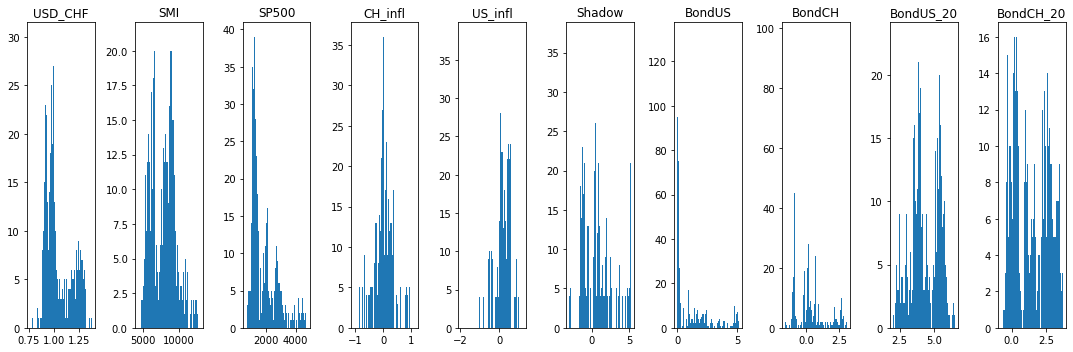

In [294]:
data = [df.USD_CHF, df.SMI, df.SP500, df.CH_infl, df.US_infl, df.Shadow, df.BondUS, df.BondCH, df.BondUS_20, df.BondCH_20]

fig = plt.figure(figsize=(15, 5))

name  = ['USD_CHF','SMI', 'SP500', 'CH_infl', 'US_infl', 'Shadow', 'BondUS', 'BondCH', 'BondUS_20', 'BondCH_20']
for i in range(len(data)):   
    plt.subplot(1,len(data),1+i)
    plt.hist(data[i], bins=150)
    plt.title(name[i])

plt.tight_layout()
plt.show()

16
2
12
Shape:             
X train     (724, 7, 10), y train     (724, 10)            
X train val (81, 7, 10) , y train val (81, 10)             
X test      (143, 7, 10) , y test      (143, 10)


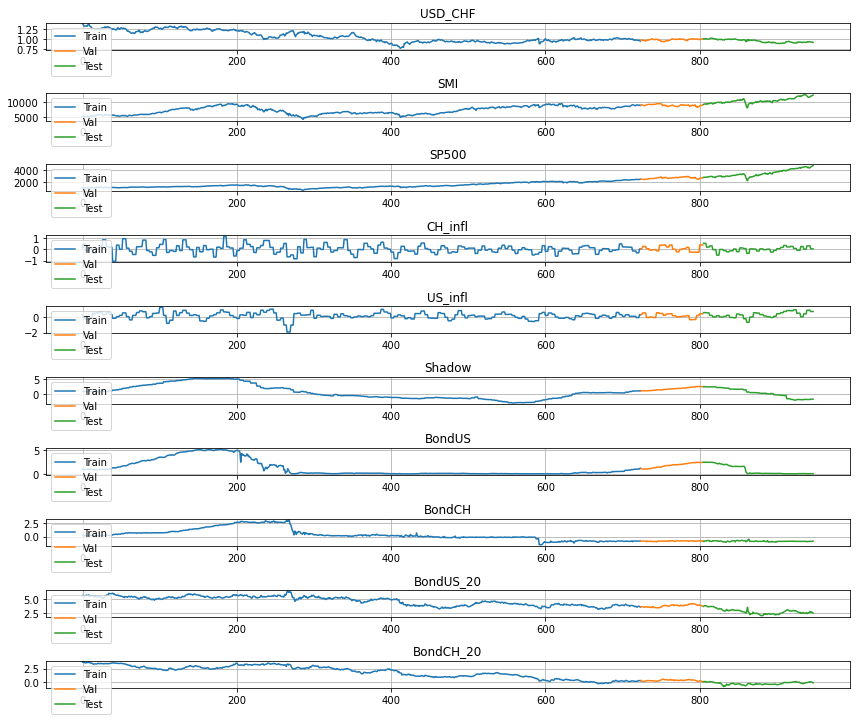

In [295]:
device = 'cpu'
LOOKBACK = 7
NORM = True
train_x, val_x, test_x, train_y, val_y, test_y, norm = pp.generate_dataset(data, lookback_=LOOKBACK, norm_=NORM, fraction_val_=0.1, fraction_test_=0.15)

l1 = len(train_x)
l2 = len(val_x) + l1
l3 = len(test_x) + l2 

fig = plt.figure(figsize=(12, 10))
nb_data = len(data)
for i in range(nb_data):
  plt.subplot(nb_data,1,i+1)
  plt.title(name[i])
  plt.plot(np.arange(l1), data[i].iloc[:l1], label='Train')
  plt.plot(np.arange(l1, l2), data[i].iloc[l1:l2], label='Val')
  plt.plot(np.arange(l2,l3), data[i].iloc[l2:l3], label='Test')
  plt.grid()
  plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [296]:
train_x[np.isnan(train_x)] = 0.5 
val_x[np.isnan(val_x)] = 0.5
test_x[np.isnan(test_x)] = 0.5
train_y[np.isnan(train_y)] = 0.5
val_y[np.isnan(val_y)] = 0.5
test_y[np.isnan(test_y)] = 0.5

# Price prediction 

### GRU 1-feature

In [297]:
model_gru_1 = ml.GRU_base(
        hidden_size=8,
        num_layers=1,
        input_size=1,
        out_features_lin=8,
        out_features_end=1,
        dropout=0.05,
        device=device)
model_gru_1.to(device)
model_gru_1

GRU_base(
  (gru): GRU(1, 8, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=8, out_features=8, bias=True)
  (fc1_bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)

100%|██████████| 350/350 [00:03<00:00, 100.32it/s]


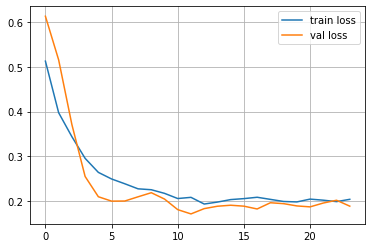

In [298]:
lr= 0.001
num_epochs= 350

train_loss, val_loss = pl.train(
    model=model_gru_1,
    train_x_ = train_x[:,:,0].reshape(-1, LOOKBACK, 1),
    train_y_ = train_y[:,0].reshape(-1,1),
    val_x_ = val_x[:,:,0].reshape(-1, LOOKBACK, 1),
    val_y_= val_y[:,0].reshape(-1,1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    device_=device,
    verbose = 0)
    
chunksize= int(num_epochs/25)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show()

In [299]:
outputs_gru_1, targets, MSE = pl.evaluate(model_gru_1, test_x[:,:,0].reshape(-1, LOOKBACK,1), test_y[:,0].reshape(-1,1), device='cpu') 

tuple_min_max= norm[2]
outputs_gru_1 = pp.min_max_norm_inverse(outputs_gru_1.reshape(-1,), tuple_min_max_=tuple_min_max) 
t = pp.min_max_norm_inverse(targets.reshape(-1,) , tuple_min_max_=tuple_min_max)
REAL_MSE_gru_1 = np.mean((outputs_gru_1-t)**2)
print(f"REAL MSE: {REAL_MSE_gru_1:0.08f}")
REAL_ACC_gru_1 = pl.direction_accuracy(outputs_gru_1, t)
print(f"ACC {REAL_ACC_gru_1:0.03f}")

MSE:  0.24247
REAL MSE: 0.00010163
ACC 0.423


### GRU 10-feature

In [300]:
model_gru_10 = ml.GRU_base(
        hidden_size=64,
        num_layers=1,
        input_size=10,
        out_features_lin=64,
        out_features_end=1,
        dropout=0.05,
        device=device)
model_gru_10.to(device)
model_gru_10

GRU_base(
  (gru): GRU(10, 64, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=64, out_features=64, bias=True)
  (fc1_bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)

100%|██████████| 30/30 [00:03<00:00,  9.66it/s]


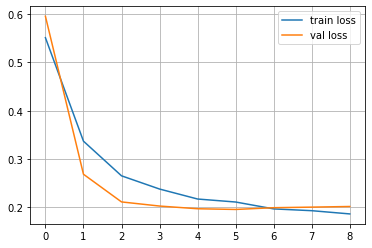

In [301]:
lr= 0.0001
num_epochs= 30
train_loss, val_loss = pl.train(
    model=model_gru_10,
    train_x_ = train_x,
    train_y_ = train_y[:,0].reshape(-1,1),
    val_x_ = val_x,
    val_y_= val_y[:,0].reshape(-1,1),
    batch_size_= 32,
    num_epochs_=num_epochs,
    lr_ = lr,
    device_ = device,
    verbose = 0)
    
chunksize= int(num_epochs/10)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show()

In [302]:
outputs_gru_10, targets, MSE = pl.evaluate(model_gru_10, test_x, test_y[:,0].reshape(-1,1), device='cpu') 

tuple_min_max= norm[2]
outputs_gru_10 = pp.min_max_norm_inverse(outputs_gru_10.reshape(-1,), tuple_min_max_=tuple_min_max) 
t = pp.min_max_norm_inverse(targets.reshape(-1,) , tuple_min_max_=tuple_min_max)

REAL_MSE_gru_10 = np.mean((outputs_gru_10-t)**2)
print(f"REAL MSE: {REAL_MSE_gru_10:0.08f}")
REAL_ACC_gru_10 = pl.direction_accuracy(outputs_gru_10, t)
print(f"ACC: {REAL_ACC_gru_10:0.03f}")


MSE:  0.32272
REAL MSE: 0.00013953
ACC: 0.430


### GRU + Auto-Encoder 1-feature 

In [303]:
model_autoenc_1 = ml.auto_encoder(nb_channel_conv=3)
model_autoenc_1.load_state_dict(torch.load('Helper/model/model_autoenc_1_week.pth'))
model_autoenc_1.to(device)
model_autoenc_1

auto_encoder(
  (relu): ReLU()
  (conv1): Conv1d(1, 3, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(3, 3, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(3, 3, kernel_size=(3,), stride=(1,))
  (conv1_t): ConvTranspose1d(3, 3, kernel_size=(3,), stride=(1,))
  (conv2_t): ConvTranspose1d(3, 3, kernel_size=(3,), stride=(1,))
  (conv3_t): ConvTranspose1d(3, 1, kernel_size=(3,), stride=(1,))
)

In [304]:
model_gru_autoenc_1 = ml.GRU_base(
        hidden_size=8,
        num_layers=1,
        input_size=1,
        out_features_lin=8,
        out_features_end=1,
        dropout=0.05,
        device=device)
model_gru_autoenc_1.to(device)
model_gru_autoenc_1

GRU_base(
  (gru): GRU(1, 8, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=8, out_features=8, bias=True)
  (fc1_bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)

100%|██████████| 400/400 [00:03<00:00, 105.79it/s]


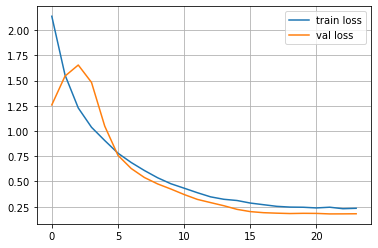

In [305]:
model_autoenc_1.eval()
inp1 = torch.from_numpy(train_x[:,:,0].reshape(-1, 1, LOOKBACK))
out = model_autoenc_1(inp1.to(device).float())
train_x_smooth = out.cpu().detach().numpy().reshape(-1, LOOKBACK, 1)

inp2 = torch.from_numpy(val_x[:,:,0].reshape(-1, 1, LOOKBACK))
out = model_autoenc_1(inp2.to(device).float())
val_x_smooth = out.cpu().detach().numpy().reshape(-1, LOOKBACK, 1)

lr= 0.001
num_epochs= 400 

train_loss, val_loss = pl.train(
    model=model_gru_autoenc_1,
    train_x_ = train_x_smooth,
    train_y_ = train_y[:,0].reshape(-1,1),
    val_x_ = val_x_smooth,
    val_y_= val_y[:,0].reshape(-1,1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    device_=device,
    verbose = 0)
    
chunksize= int(num_epochs/25)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show()

In [306]:
inp3 = torch.from_numpy(test_x[:,:,0].reshape(-1, 1, LOOKBACK))
out = model_autoenc_1(inp3.to(device).float())
test_x_smooth = out.cpu().detach().numpy().reshape(-1, LOOKBACK, 1)

outputs_gru_autoenc_1, targets, MSE = pl.evaluate(model_gru_autoenc_1, test_x_smooth, test_y[:,0].reshape(-1,1), device='cpu') 

tuple_min_max= norm[2]
outputs_gru_autoenc_1 = pp.min_max_norm_inverse(outputs_gru_autoenc_1.reshape(-1,), tuple_min_max_=tuple_min_max) 
t = pp.min_max_norm_inverse(targets.reshape(-1,), tuple_min_max_=tuple_min_max)

REAL_MSE_gru_autoenc_1 = np.mean((outputs_gru_autoenc_1-t)**2)
print(f"REAL MSE: {REAL_MSE_gru_autoenc_1:0.08f}") 

REAL_ACC_gru_autoenc_1 = pl.direction_accuracy(outputs_gru_autoenc_1, t)
print(f"ACC: {REAL_ACC_gru_autoenc_1:0.03f}")

MSE:  0.26325
REAL MSE: 0.00010837
ACC: 0.479


### Dense + latent space Auto-Encoder 1-feature 

In [307]:
model_dense_autoenc_1 = ml.Dense(
    num_layers=2,
    layer_size=8,
    input_size=3,
    output_size=1,
    dropout=0.05
    )
model_dense_autoenc_1.to(device)
model_dense_autoenc_1

Dense(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=8, bias=True)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.05, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=8, bias=True)
    (5): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.05, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=8, out_features=1, bias=True)
  )
)

100%|██████████| 500/500 [00:02<00:00, 184.02it/s]


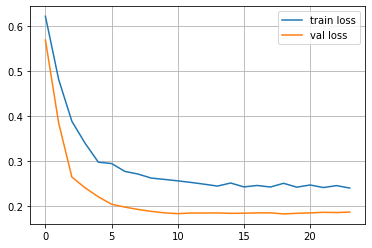

In [308]:
model_autoenc_1.eval()
inp1 = torch.from_numpy(train_x[:,:,0].reshape(-1, 1, LOOKBACK))
out, latent = model_autoenc_1(inp1.to(device).float(), return_latent=True)
train_x_smooth = latent.cpu().detach().numpy().reshape(-1, 3)

inp2 = torch.from_numpy(val_x[:,:,0].reshape(-1, 1, LOOKBACK))
out, latent = model_autoenc_1(inp2.to(device).float(), return_latent=True)
val_x_smooth = latent.cpu().detach().numpy().reshape(-1, 3)

lr= 0.001
num_epochs= 500 

train_loss, val_loss = pl.train(
    model=model_dense_autoenc_1,
    train_x_ = train_x_smooth,
    train_y_ = train_y[:,0].reshape(-1,1),
    val_x_ = val_x_smooth,
    val_y_= val_y[:,0].reshape(-1,1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=0.001,
    device_=device,
    verbose = 0)
    
chunksize= int(num_epochs/25)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show()


In [309]:
inp3 = torch.from_numpy(test_x[:,:,0].reshape(-1, 1, LOOKBACK))
out, latent = model_autoenc_1(inp3.to(device).float(), return_latent=True)
test_x_smooth = latent.cpu().detach().numpy().reshape(-1,3)

outputs_dense_autoenc_1, targets, MSE = pl.evaluate(model_dense_autoenc_1, test_x_smooth, test_y[:,0].reshape(-1,1), device='cpu') 

tuple_min_max= norm[2]
outputs_dense_autoenc_1 = pp.min_max_norm_inverse(outputs_dense_autoenc_1.reshape(-1,), tuple_min_max_=tuple_min_max) 
t = pp.min_max_norm_inverse(targets.reshape(-1,), tuple_min_max_=tuple_min_max)

REAL_MSE_dense_autoenc_1 = np.mean((outputs_dense_autoenc_1-t)**2)
print(f"REAL MSE: {REAL_MSE_dense_autoenc_1:0.08f}")

REAL_ACC_dense_autoenc_1 = pl.direction_accuracy(outputs_dense_autoenc_1, t)
print(f"ACC: {REAL_ACC_dense_autoenc_1:0.03f}")

MSE:  0.25291
REAL MSE: 0.00009917
ACC: 0.465


### GRU + Auto-Encoder 10-features

In [310]:
model_autoenc_10 = ml.auto_encoder(input_size=10,
    nb_channel_conv=30)
model_autoenc_10.load_state_dict(torch.load('Helper/model/model_autoenc_10_week.pth'))
model_autoenc_10.to(device)
model_autoenc_10

auto_encoder(
  (relu): ReLU()
  (conv1): Conv1d(10, 30, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(30, 30, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(30, 30, kernel_size=(3,), stride=(1,))
  (conv1_t): ConvTranspose1d(30, 30, kernel_size=(3,), stride=(1,))
  (conv2_t): ConvTranspose1d(30, 30, kernel_size=(3,), stride=(1,))
  (conv3_t): ConvTranspose1d(30, 10, kernel_size=(3,), stride=(1,))
)

In [311]:
model_gru_autoenc_10 = ml.GRU_base(
        hidden_size=65,
        num_layers=1,
        input_size=10,
        out_features_lin=65,
        out_features_end=1,
        dropout=0.05,
        device=device)
model_gru_autoenc_10.to(device)
model_gru_autoenc_10

GRU_base(
  (gru): GRU(10, 65, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(65, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=65, out_features=65, bias=True)
  (fc1_bn): BatchNorm1d(65, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=65, out_features=1, bias=True)
  (relu): ReLU()
)

100%|██████████| 30/30 [00:03<00:00,  8.74it/s]


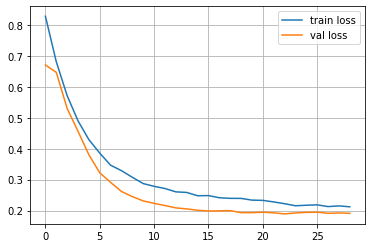

In [312]:
model_autoenc_10.eval()
inp1 = torch.from_numpy(np.swapaxes(train_x,1,2))
out = model_autoenc_10(inp1.to(device).float())
train_x_smooth = np.swapaxes(out.cpu().detach().numpy(),2,1)

inp2 = torch.from_numpy(np.swapaxes(val_x,1,2))
out = model_autoenc_10(inp2.to(device).float())
val_x_smooth = np.swapaxes(out.cpu().detach().numpy(),2,1)

lr= 0.0001
num_epochs= 30

train_loss, val_loss = pl.train(
    model=model_gru_autoenc_10,
    train_x_ = train_x_smooth,
    train_y_ = train_y[:,0].reshape(-1,1),
    val_x_ = val_x_smooth,
    val_y_= val_y[:,0].reshape(-1,1),
    batch_size_=32,
    num_epochs_=num_epochs,
    lr_=lr,
    device_=device,
    verbose = 0)
    
chunksize= int(num_epochs/25)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show()


In [313]:
inp3 = torch.from_numpy(np.swapaxes(test_x,1,2))
out = model_autoenc_10(inp3.to(device).float())
test_x_smooth = np.swapaxes(out.cpu().detach().numpy(),2,1)

outputs_gru_autoenc_10, targets, MSE = pl.evaluate(model_gru_autoenc_10, test_x_smooth, test_y[:,0].reshape(-1,1), device='cpu') 

tuple_min_max= norm[2]
outputs_gru_autoenc_10 = pp.min_max_norm_inverse(outputs_gru_autoenc_10.reshape(-1,), tuple_min_max_=tuple_min_max) 
t = pp.min_max_norm_inverse(targets.reshape(-1,), tuple_min_max_=tuple_min_max)

REAL_MSE_gru_autoenc_10 = np.mean((outputs_gru_autoenc_10-t)**2)
print(f"REAL MSE: {REAL_MSE_gru_autoenc_10:0.08f}")

REAL_ACC_gru_autoenc_10 = pl.direction_accuracy(outputs_gru_autoenc_10, t)
print(f"ACC: {REAL_ACC_gru_autoenc_10:0.03f}")

MSE:  0.32274
REAL MSE: 0.00013284
ACC: 0.479


### Dense + latent space Auto-Encoder 10-feature 

In [314]:
model_dense_autoenc_10 = ml.Dense(
    num_layers=2,
    layer_size=32,
    input_size=30,
    output_size=1,
    dropout=0.05
    )
model_dense_autoenc_10.to(device)
model_dense_autoenc_10

Dense(
  (net): Sequential(
    (0): Linear(in_features=30, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.05, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.05, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)

100%|██████████| 100/100 [00:00<00:00, 183.78it/s]


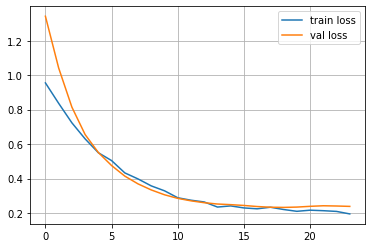

In [315]:
model_autoenc_10.eval()
inp1 = torch.from_numpy(np.swapaxes(train_x,1,2))
out, latent = model_autoenc_10(inp1.to(device).float(), return_latent=True)

train_x_smooth = latent.cpu().detach().numpy().reshape(-1, 30)

inp2 = torch.from_numpy(np.swapaxes(val_x,1,2))
out, latent = model_autoenc_10(inp2.to(device).float(), return_latent=True)
val_x_smooth = latent.cpu().detach().numpy().reshape(-1, 30)

lr= 0.001
num_epochs= 100 

train_loss, val_loss = pl.train(
    model=model_dense_autoenc_10,
    train_x_ = train_x_smooth,
    train_y_ = train_y[:,0].reshape(-1,1),
    val_x_ = val_x_smooth,
    val_y_= val_y[:,0].reshape(-1,1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    device_=device,
    verbose = 0)
    
chunksize= int(num_epochs/25)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show()

In [316]:
inp3 = torch.from_numpy(np.swapaxes(test_x,1,2))
out, latent = model_autoenc_10(inp3.to(device).float(), return_latent=True)
test_x_smooth = latent.cpu().detach().numpy().reshape(-1,30)

outputs_dense_autoenc_10, targets, MSE = pl.evaluate(model_dense_autoenc_10, test_x_smooth, test_y[:,0].reshape(-1,1), device='cpu') 

tuple_min_max= norm[2]
outputs_dense_autoenc_10 = pp.min_max_norm_inverse(outputs_dense_autoenc_10.reshape(-1,), tuple_min_max_=tuple_min_max) 
t = pp.min_max_norm_inverse(targets.reshape(-1,), tuple_min_max_=tuple_min_max)

REAL_MSE_dense_autoenc_10 = np.mean((outputs_dense_autoenc_10-t)**2)
print(f"REAL MSE: {REAL_MSE_dense_autoenc_10:0.08f}")

REAL_ACC_dense_autoenc_10 = pl.direction_accuracy(outputs_dense_autoenc_10, t)
print(f"ACC {REAL_ACC_dense_autoenc_10:0.03f}")

MSE:  0.31425
REAL MSE: 0.00015154
ACC 0.514


# Result 

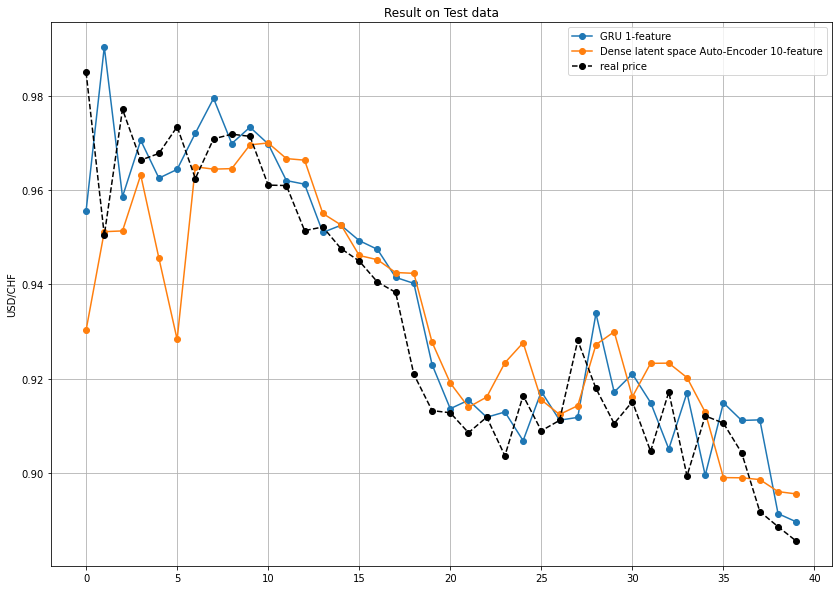

In [323]:
range_ = range(50,90)
plt.figure(figsize=(14, 10))
plt.title("Result on Test data")
plt.plot(outputs_gru_1[range_], "-o", label="GRU 1-feature")
#plt.plot(outputs_gru_10[range_], "-o", label="GRU 10-features")
#plt.plot(outputs_gru_autoenc_1[range_], "-o", label="GRU Auto-Encoder 1-feature")
#plt.plot(outputs_dense_autoenc_1[range_], "-o", label="Dense latent space Auto-Encoder 1-feature")
#plt.plot(outputs_gru_autoenc_10[range_], "-o", label="GRU Auto-Encoder 10-feature")
plt.plot(outputs_dense_autoenc_10[range_], "-o", label="Dense latent space Auto-Encoder 10-feature")
plt.plot(t[range_], "--o", c='k',label="real price")
plt.grid()
plt.ylabel("USD/CHF")
plt.legend()
plt.show()

In [318]:
print(f"MSE GRU 1-feature:                              { REAL_MSE_gru_1: 0.08f}")
print(f"MSE GRU 10-features:                            { REAL_MSE_gru_10: 0.08f}")
print(f"MSE GRU Auto-Encoder 1-feature:                 { REAL_MSE_gru_autoenc_1: 0.08f}")
print(f"MSE Dense latent space Auto-Encoder 1-feature:  { REAL_MSE_dense_autoenc_1: 0.08f}")
print(f"MSE GRU Auto-Encoder 10-feature:                { REAL_MSE_gru_autoenc_10: 0.08f}")
print(f"MSE Dense latent space Auto-Encoder 10-feature: { REAL_MSE_dense_autoenc_10: 0.08f}")


MSE GRU 1-feature:                               0.00010163
MSE GRU 10-features:                             0.00013953
MSE GRU Auto-Encoder 1-feature:                  0.00010837
MSE Dense latent space Auto-Encoder 1-feature:   0.00009917
MSE GRU Auto-Encoder 10-feature:                 0.00013284
MSE Dense latent space Auto-Encoder 10-feature:  0.00015154


In [319]:
print(f"ACC GRU 1-feature:                               { REAL_ACC_gru_1: 0.03f}")
print(f"ACC GRU 10-features:                             { REAL_ACC_gru_10: 0.03f}")
print(f"ACC GRU Auto-Encoder 1-feature:                  { REAL_ACC_gru_autoenc_1: 0.03f}")
print(f"ACC Dense latent space Auto-Encoder 1-feature:   { REAL_ACC_dense_autoenc_1: 0.03f}")
print(f"ACC GRU Auto-Encoder 10-feature:                 { REAL_ACC_gru_autoenc_10: 0.03f}")
print(f"ACC Dense latent space Auto-Encoder 10-feature:  { REAL_ACC_dense_autoenc_10: 0.03f}")


ACC GRU 1-feature:                                0.423
ACC GRU 10-features:                              0.430
ACC GRU Auto-Encoder 1-feature:                   0.479
ACC Dense latent space Auto-Encoder 1-feature:    0.465
ACC GRU Auto-Encoder 10-feature:                  0.479
ACC Dense latent space Auto-Encoder 10-feature:   0.514


In [320]:
print(f"all 0 : { 1 -(test_y[1:,0] > test_y[:1,0]).sum()/ len(test_y):0.03f}")

all 0 : 0.524


# TODO:

- add more data daily (bond 2)
- check with norm and with out norm of output [OK]
- auto encode 1 & 2 add dense for with latent space prediction [OK]
- save_model_weight [OK]
- add trend NN (gru, AE, gru + AE, ... test in an other file)  
- add regression on output: x and x^2
- add aux block (gru, AE, gru + AE, ... test in an other file)
- accuracy score [OK]
 